In [1]:
import pandas as pd
import numpy as np
from typing import Dict, Any, List
import warnings
import io
import base64
from IPython.display import display, HTML
warnings.filterwarnings('ignore')
from phik import phik_matrix
from scipy import stats
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# локальный файл
import script as sc

# Настройка Altair
alt.data_transformers.disable_max_rows() 
alt.data_transformers.enable('default')
alt.themes.enable('default')              

# палитра – Визуализация
colors = ["#59C5C7", "#157486", "#231F20", "#F16669", "#FFD73A", "#8B4A9C", "#2E8B57", "#FF6B35", "#4A90E2", "#A0522D", "#DC143C", "#32CD32", "#FF1493", "#00CED1", "#9932CC", "#FF8C00", "#228B22", "#FF69B4", "#20B2AA", "#8B008B", "#FFB6C1", "#3CB371", "#FF4500", "#4169E1", "#B8860B", "#FF6347", "#2F4F4F", "#DA70D6", "#00FA9A", "#CD5C5C", "#40E0D0", "#9370DB", "#FFA07A", "#008B8B", "#D2691E", "#FF7F50", "#6A5ACD", "#98FB98", "#F08080", "#87CEEB", "#DDA0DD", "#90EE90", "#F0E68C", "#E6E6FA", "#FFA500", "#AFEEEE", "#DB7093", "#F5DEB3", "#FF00FF", "#7FFFD4", "#C71585", "#FFDAB9", "#6495ED", "#DEB887", "#FF1493", "#B0E0E6", "#CD853F", "#FFEFD5", "#FF69B4", "#F0FFFF", "#D2B48C", "#FFFAF0", "#BA55D3", "#E0FFFF", "#A52A2A", "#F5F5DC", "#9400D3", "#FAF0E6", "#B22222", "#FDF5E6", "#4B0082", "#FFFACD", "#8B0000", "#F0FFF0", "#9932CC", "#F5FFFA", "#800000", "#F0F8FF", "#8A2BE2", "#FFF8DC", "#191970", "#FFEBCD", "#483D8B", "#FFE4E1", "#2F4F4F", "#DCDCDC", "#8FBC8F", "#F8F8FF", "#556B2F", "#FFFAFA", "#6B8E23", "#F0F0F0"]
color_scale = alt.Scale(range=colors)

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df.sample(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
847,2023,SE,FT,Machine Learning Engineer,153400,USD,153400,US,0,US,M
3105,2022,SE,FT,Machine Learning Engineer,180000,USD,180000,US,100,US,M
1920,2022,SE,FT,Data Engineer,175000,USD,175000,US,0,US,M


In [4]:
analyzer = sc.DataAnalyzerTable(df)
analyzer.display_analysis_table()  

🔍 СВОДНАЯ ТАБЛИЦА АНАЛИЗА ДАННЫХ
📊 Датасет: 3,755 строк × 11 столбцов
💾 Размер в памяти: 1.64 MB


,Столбец,Описание,Кол-во значений,Типы данных,NaN (%),Кол-во уникальных,Примеры значений
0,work_year,Год выплаты зарплаты,3755,int,0.0,4,"Все (4): [2023, 2022, 2020, 2021]"
1,experience_level,Уровень опыта работы,3755,str,0.0,4,"Все (4): ['SE', 'MI', 'EN', 'EX']"
2,employment_type,Тип занятости,3755,str,0.0,4,"Все (4): ['FT', 'CT', 'FL', 'PT']"
3,job_title,Должность сотрудника,3755,str,0.0,93,Примеры (93 всего): ['Principal Data Scientist...
4,salary,Сумма зарплаты (GROSS),3755,int,0.0,815,"Примеры (815 всего): [80000, 30000, 25500, 175..."
5,salary_currency,Валюта зарплаты (ISO 4217),3755,str,0.0,20,"Примеры (20 всего): ['EUR', 'USD', 'INR', 'HKD..."
6,salary_in_usd,Зарплата в USD (целевая),3755,int,0.0,1035,"Примеры (1035 всего): [85847, 30000, 25500, 17..."
7,employee_residence,Страна сотрудника (ISO 3166),3755,str,0.0,78,"Примеры (78 всего): ['ES', 'US', 'CA', 'DE', '..."
8,remote_ratio,Доля удалённой работы,3755,int,0.0,3,"Все (3): [100, 0, 50]"
9,company_location,Страна компании,3755,str,0.0,72,"Примеры (72 всего): ['ES', 'US', 'CA', 'DE', '..."


In [5]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 1171


In [6]:
df = df.drop_duplicates()
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


#### Данные готовы для дальнейшего анализа

# 
# 

### Распределение заработной платы по позициям с выявлением аномалий

In [7]:
# Боксплот зарплат по должностям с выбросами
chart = alt.Chart(df).mark_boxplot(
    size=10,         
    outliers=True,         
    color='darkblue',          
    opacity=0.7                 
).add_selection(
    alt.selection_interval()
).encode(
    x=alt.X('salary_in_usd:Q', 
           title='Зарплата (USD)', 
           scale=alt.Scale(zero=False)),
    y=alt.Y('job_title:O', 
           title='Должность', 
           sort=alt.EncodingSortField(field='salary_in_usd', op='median', order='descending'),
           axis=alt.Axis(labelLimit=200)),  
    tooltip=['job_title:N', 'salary_in_usd:Q']
).properties(
    title='Распределение зарплат по должностям',
    width=600,
    height=1200
)
chart.show()  

alt.Chart(...)

In [8]:
# Топ должностей по медианной зарплате
top_jobs = df.groupby('job_title')['salary_in_usd'].agg(['median', 'mean', 'count']).reset_index()
top_jobs = top_jobs.sort_values('median', ascending=False)
print("Топ-5 должностей по медианной зарплате:")
for i, row in top_jobs.head().iterrows():
    print(f"{row['job_title']}: ${row['median']:,.0f} (медиана), ${row['mean']:,.0f} (среднее)")

Топ-5 должностей по медианной зарплате:
Data Science Tech Lead: $375,000 (медиана), $375,000 (среднее)
Cloud Data Architect: $250,000 (медиана), $250,000 (среднее)
Data Lead: $212,500 (медиана), $212,500 (среднее)
Data Analytics Lead: $211,254 (медиана), $211,254 (среднее)
Head of Data: $202,500 (медиана), $183,858 (среднее)


In [9]:
print("\nАномалии в заработной плате:")
for job in df['job_title'].unique():
    job_data = df[df['job_title'] == job]['salary_in_usd']
    Q1 = job_data.quantile(0.25)
    Q3 = job_data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = job_data[(job_data < Q1 - 1.5*IQR) | (job_data > Q3 + 1.5*IQR)]
    if len(outliers) > 0:
        print(f"  {job}: {len(outliers)} выбросов (max: ${outliers.max():,.0f})")


Аномалии в заработной плате:
  Principal Data Scientist: 1 выбросов (max: $416,000)
  Data Scientist: 4 выбросов (max: $412,000)
  Applied Scientist: 1 выбросов (max: $350,000)
  Data Analyst: 7 выбросов (max: $430,967)
  Analytics Engineer: 2 выбросов (max: $289,800)
  Machine Learning Engineer: 1 выбросов (max: $342,300)
  Data Engineer: 5 выбросов (max: $324,000)
  Data Architect: 2 выбросов (max: $376,080)
  Research Scientist: 2 выбросов (max: $450,000)
  Data Analytics Manager: 1 выбросов (max: $204,500)
  Applied Data Scientist: 1 выбросов (max: $380,000)
  Machine Learning Researcher: 1 выбросов (max: $50,000)
  Applied Machine Learning Scientist: 1 выбросов (max: $423,000)
  BI Developer: 1 выбросов (max: $197,000)
  Machine Learning Software Engineer: 2 выбросов (max: $375,000)
  Machine Learning Developer: 1 выбросов (max: $180,000)
  Lead Data Engineer: 1 выбросов (max: $276,000)


# 
# 

### ВЛИЯНИЕ УДАЛЕННОЙ РАБОТЫ НА ЗАРПЛАТУ

In [10]:
# Корреляция между удаленной работой и зарплатой
correlation = df['remote_ratio'].corr(df['salary_in_usd'])
print(f"Корреляция между удаленной работой и зарплатой: {correlation:.3f}")

Корреляция между удаленной работой и зарплатой: -0.085


### Зависимость не наблюдается

In [11]:
# Зарплата vs удаленная работа
remote_labels = {0: 'Офис (0%)', 50: 'Гибрид (50%)', 100: 'Удаленно (100%)'}
df['remote_label'] = df['remote_ratio'].map(remote_labels)

chart = alt.Chart(df).mark_boxplot(size=80).encode(
    x=alt.X('remote_label:O', title='Тип работы', sort=['Офис (0%)', 'Гибрид (50%)', 'Удаленно (100%)']),
    y=alt.Y('salary_in_usd:Q', title='Зарплата (USD)', scale=alt.Scale(zero=False)),
    color=alt.Color('remote_label:N', scale=alt.Scale(range=colors[:3]), legend=None),
    tooltip=['remote_label:N', 'salary_in_usd:Q']
).properties(
    title='Зарплата vs Тип работы',
    width=500,
    height=400
)

chart.show()

# Статистика по типам работы
remote_stats = df.groupby('remote_ratio')['salary_in_usd'].agg(['mean', 'median', 'count'])
print("\nСтатистика по типам работы:")
for ratio, stats in remote_stats.iterrows():
    label = remote_labels[ratio]
    print(f"  {label}: медиана ${stats['median']:,.0f}, среднее ${stats['mean']:,.0f}, количество {stats['count']}")


alt.Chart(...)


Статистика по типам работы:
  Офис (0%): медиана $137,500, среднее $143,690, количество 1186.0
  Гибрид (50%): медиана $63,312, среднее $78,487, количество 187.0
  Удаленно (100%): медиана $130,000, среднее $131,822, количество 1211.0


### Офисный формат показывает наиболее высокие зарплаты по всем ключевым показателям:

- Медиана: 137,500 (офис) vs 130,000 (удаленка) vs 63,312 (гибрид)
- Q3: 182,000 (офис) vs 175,000 (удаленка) vs 100,000 (гибрид)

##### Удаленный формат незначительно уступает офисному в верхних квартилях, но имеет более широкий разброс (Q1 = 84,000 против 100,000 в офисе).
##### Гибридный формат существенно отстает - медиана почти в 2 раза ниже офисного формата.
Различия в медианах составляют:\
Офис vs Удаленка: 7,500 (5%)\
Офис vs Гибрид: 74,000 (54%)\
Удаленка vs Гибрид: 67,000 (52%)

# 
# 

### Зависимость зарплаты от размера компании

In [12]:
size_labels = {'S': 'Малая', 'M': 'Средняя', 'L': 'Большая'}
df['size_label'] = df['company_size'].map(size_labels)

chart = alt.Chart(df).mark_boxplot(size=80).encode(
    x=alt.X('size_label:O', title='Размер компании', sort=['Малая', 'Средняя', 'Большая']),
    y=alt.Y('salary_in_usd:Q', title='Зарплата (USD)', scale=alt.Scale(zero=False)),
    color=alt.Color('size_label:N', scale=alt.Scale(range=colors[3:6]), legend=None),
    tooltip=['size_label:N', 'salary_in_usd:Q']
).properties(
    title='Зарплата vs Размер компании',
    width=500,
    height=400
)

chart.show()

# Статистика 
size_stats = df.groupby('company_size')['salary_in_usd'].agg(['mean', 'median', 'count'])
print("Статистика по размерам компаний:")
for size, stats in size_stats.iterrows():
    label = size_labels[size]
    print(f"  {label}: медиана ${stats['median']:,.0f}, среднее ${stats['mean']:,.0f}")

alt.Chart(...)

Статистика по размерам компаний:
  Большая: медиана $100,000, среднее $113,202
  Средняя: медиана $137,068, среднее $141,475
  Малая: медиана $62,726, среднее $78,364


### Средние компании показывают наилучшие результаты по зарплатам:

- Самая высокая медиана (137 000 против 63 000 у малых и 100 000 у больших)
- Самый высокий Q1 (99 000), что означает, что даже 25% самых низкооплачиваемых сотрудников получают больше, чем в других типах компаний
- Самый высокий Q3 (180 000)

### Малые компании демонстрируют наибольший разброс:

- Широкий диапазон зарплат от 5 600 до 416 000
- Низкая медиана (63 000), но высокий максимум
- Это может указывать на присутствие как стартапов с ограниченным бюджетом, так и успешных технологических компаний

### Большие компании показывают умеренные результаты:

- Медиана выше, чем у малых компаний, но ниже, чем у средних
- Относительно стабильное распределение зарплат

# 
# 

### АНАЛИЗ ПО СТРАНАМ

In [13]:
# Популярность стран (количество вакансий)
country_counts = df['company_location'].value_counts().head(8).reset_index()
country_counts.columns = ['country', 'count']
# Добавляем русские названия стран
country_counts['country_ru'] = country_counts['country'].map(sc.country_codes).fillna(country_counts['country'])

chart = alt.Chart(country_counts).mark_bar().encode(
    x=alt.X('count:Q', title='Количество вакансий'),
    y=alt.Y('country_ru:O', title='Страна', sort='-x'),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='viridis'), legend=None),
    tooltip=['country_ru:N', 'count:Q']
).properties(
    title='Популярность стран (количество вакансий)',
    width=600,
    height=400
)
chart.show()

alt.Chart(...)

In [14]:
# Медианная зарплата по странам
country_salary = df.groupby('company_location')['salary_in_usd'].median().sort_values(ascending=False).head(8).reset_index()
country_salary.columns = ['country', 'median_salary']
# Добавляем русские названия стран
country_salary['country_ru'] = country_salary['country'].map(sc.country_codes).fillna(country_salary['country'])

chart = alt.Chart(country_salary).mark_bar().encode(
    x=alt.X('median_salary:Q', title='Медианная зарплата (USD)'),
    y=alt.Y('country_ru:O', title='Страна', sort='-x'),
    color=alt.Color('median_salary:Q', scale=alt.Scale(scheme='plasma'), legend=None),
    tooltip=['country_ru:N', 'median_salary:Q']
).properties(
    title='Медианная зарплата по странам',
    width=600,
    height=400
)
chart.show()

alt.Chart(...)

In [15]:
print("Топ-5 стран по количеству вакансий:")
for _, row in country_counts.head().iterrows():
    print(f"  {row['country_ru']}: {row['count']} вакансий")

print("\nТоп-5 стран по медианной зарплате:")
for _, row in country_salary.head().iterrows():
    print(f"  {row['country_ru']}: ${row['median_salary']:,.0f}")

Топ-5 стран по количеству вакансий:
  Соединенные Штаты Америки: 1929 вакансий
  Великобритания: 155 вакансий
  Канада: 83 вакансий
  Индия: 57 вакансий
  Германия: 55 вакансий

Топ-5 стран по медианной зарплате:
  Израиль: $271,446
  Пуэрто-Рико: $167,500
  Соединенные Штаты Америки: $145,885
  Новая Зеландия: $125,000
  Канада: $120,000


In [16]:
country_counts_all = df['company_location'].value_counts().reset_index()
country_counts_all.columns = ['country', 'count']
country_counts_all['country_ru'] = country_counts_all['country'].map(sc.country_codes).fillna(country_counts_all['country'])

In [17]:
for _, row in country_counts_all.iterrows():
    if row['country_ru'] == 'Израиль':
        print(f"  {row['country_ru']}: {row['count']} вакансий")

  Израиль: 2 вакансий


### Объем vs. Оплата
США - главный рынок для поиска работы (массовый спрос)\
Израиль - нишевый рынок с премиальной оплатой (дефицит специалистов)\
Англоязычные страны (США, Великобритания, Канада) концентрируют основную часть вакансий\
Малые рынки (Пуэрто-Рико, Новая Зеландия) могут предложить высокие зарплаты при ограниченных возможностях

**Для массового поиска работы - США, для максимальной зарплаты - специализированные рынки типа Израиля (если есть соответствующая квалификация).**

# 
# 

### МЕДИАННАЯ ЗАРПЛАТА ПО ДОЛЖНОСТЯМ

In [18]:
job_median = df.groupby('job_title')['salary_in_usd'].median().reset_index()
job_median.columns = ['job_title', 'median_salary']
# визуализация
chart = alt.Chart(job_median.sort_values('median_salary', ascending=False).head()).mark_bar().encode(
    x=alt.X('median_salary:Q', title='Медианная зарплата (USD)'),
    y=alt.Y('job_title:O', title='Должность', sort='-x'),
    color=alt.Color('median_salary:Q', scale=alt.Scale(scheme='blues'), legend=None),
    tooltip=['job_title:N', 'median_salary:Q']
).properties(
    title='Медианная зарплата по должностям',
    width=450,
    height=150
)

In [19]:
grouped_data = df.groupby('job_title')['salary_in_usd'].median().reset_index()
grouped_data['formatted_salary'] = grouped_data['salary_in_usd'].apply(lambda x: f"${x:,.0f}")
result_df = grouped_data.sort_values('salary_in_usd', ascending=False).reset_index(drop=True)
result_df.index = result_df.index + 1  

display_table = result_df[['job_title', 'formatted_salary']].rename(columns={
    'job_title': 'Профессия',
    'formatted_salary': 'Медианная зарплата'
})

sc.make_scrollable_table(display_table)

,Профессия,Медианная зарплата
1,Data Science Tech Lead,"$375,000"
2,Cloud Data Architect,"$250,000"
3,Data Lead,"$212,500"
4,Data Analytics Lead,"$211,254"
5,Head of Data,"$202,500"
6,Principal Data Engineer,"$192,500"
7,Applied Scientist,"$192,000"
8,Principal Machine Learning Engineer,"$190,000"
9,Data Infrastructure Engineer,"$183,655"
10,Machine Learning Software Engineer,"$181,800"


In [20]:
chart.show()

alt.Chart(...)

## Доминирование лидерских позиций - Data Science Tech Lead значительно опережает остальные должности ($375,000), что на 50% выше следующей позиции.
#### Премиум за техническое лидерство - топ-6 позиций представлены исключительно senior и lead ролями, подчеркивая высокую ценность опыта и управленческих навыков.
Градация по специализации:

- Техническое лидерство (Tech Lead) - максимум
- Архитектурные роли (Cloud Data Architect) - $250K

- Управленческие позиции (Data Lead, Head of Data) - $200-210K
- Инженерные lead-роли (Principal Data Engineer) - около $190K
  

***
Рынок четко премирует комбинацию технической экспертизы и лидерских компетенций, создавая значительный разрыв между топ-менеджментом и рядовыми специалистами.
***

# 
# 

### Изменение зарплат с 2020 по 2023

In [21]:
# Общий анализ рынка
market_trend = df.groupby('work_year')['salary_in_usd'].agg(['median', 'mean', 'std', 'count']).reset_index()
market_2020 = market_trend[market_trend['work_year'] == 2020].iloc[0] if len(market_trend[market_trend['work_year'] == 2020]) > 0 else None
market_2023 = market_trend[market_trend['work_year'] == 2023].iloc[0] if len(market_trend[market_trend['work_year'] == 2023]) > 0 else None

if market_2020 is not None and market_2023 is not None:
    median_change = (market_2023['median'] - market_2020['median']) / market_2020['median'] * 100
    mean_change = (market_2023['mean'] - market_2020['mean']) / market_2020['mean'] * 100

# Анализ по всем должностям
salary_2020 = df[df['work_year'] == 2020].groupby('job_title')['salary_in_usd'].agg(['median', 'count', 'std']).reset_index()
salary_2023 = df[df['work_year'] == 2023].groupby('job_title')['salary_in_usd'].agg(['median', 'count', 'std']).reset_index()

# Объединяем данные
salary_comparison = pd.merge(salary_2020, salary_2023, on='job_title', suffixes=('_2020', '_2023'))

# Рассчитываем изменения
salary_comparison['change_pct'] = (salary_comparison['median_2023'] - salary_comparison['median_2020']) / salary_comparison['median_2020'] * 100
salary_comparison['change_abs'] = salary_comparison['median_2023'] - salary_comparison['median_2020']

# Используем все должности (убираем фильтр по минимальному количеству наблюдений)
reliable_jobs = salary_comparison.copy()

# Категоризация изменений
def categorize_change(change_pct):
    if change_pct >= 50:
        return "Взлет"
    elif change_pct >= 20:
        return "Сильный рост"
    elif change_pct >= 10:
        return "Умеренный рост"
    elif change_pct >= -10:
        return "Стабильность"
    elif change_pct >= -20:
        return "Умеренное снижение"
    else:
        return "Сильное снижение"

reliable_jobs['category'] = reliable_jobs['change_pct'].apply(categorize_change)

# Считаем распределение по категориям
category_stats = reliable_jobs['category'].value_counts()

# Анализ волатильности рынка
change_stats = reliable_jobs['change_pct'].describe()

# Топ растущих и падающих
top_changes = pd.concat([
    reliable_jobs.nlargest(5, 'change_pct'),
    reliable_jobs.nsmallest(5, 'change_pct')
])

bar_chart = alt.Chart(top_changes).mark_bar().encode(
    y=alt.Y('job_title:N', sort='-x', title='Должность'),
    x=alt.X('change_pct:Q', title='Изменение (%)'),
    color=alt.Color('change_pct:Q', 
                   scale=alt.Scale(scheme='redyellowgreen', reverse=True),
                   title='Изменение (%)')
).properties(
    title='Топ-5 растущих и падающих должностей',
    width=600,
    height=300
)

# Экспорт результатов
reliable_jobs.to_csv('salary_analysis_2020_2023.csv', index=False)

# Взвешенный анализ рынка
reliable_jobs['weighted_change'] = reliable_jobs['change_pct'] * reliable_jobs['count_2023']
total_positions_2023 = reliable_jobs['count_2023'].sum()
market_weighted_change = reliable_jobs['weighted_change'].sum() / total_positions_2023

# Анализ по уровням зарплат
def salary_tier(salary):
    if salary >= 200000:
        return "Высокий (200k+)"
    elif salary >= 100000:
        return "Средний-высокий (100-200k)"
    elif salary >= 50000:
        return "Средний (50-100k)"
    else:
        return "Низкий (<50k)"

reliable_jobs['salary_tier_2020'] = reliable_jobs['median_2020'].apply(salary_tier)
tier_analysis = reliable_jobs.groupby('salary_tier_2020')['change_pct'].agg(['mean', 'median', 'count']).round(1)

# Анализ новых и исчезнувших должностей
all_jobs_2020 = set(df[df['work_year'] == 2020]['job_title'].unique())
all_jobs_2023 = set(df[df['work_year'] == 2023]['job_title'].unique())

new_jobs = all_jobs_2023 - all_jobs_2020
disappeared_jobs = all_jobs_2020 - all_jobs_2023

In [22]:
print("ТОП-10 ДОЛЖНОСТЕЙ ПО РОСТУ:")
print("-"*50)
top_growth = reliable_jobs.nlargest(10, 'change_pct')
for _, row in top_growth.iterrows():
    print(f"  {row['job_title'][:40]:<40} {row['change_pct']:+6.1f}% (${row['median_2020']:,.0f} → ${row['median_2023']:,.0f})")


ТОП-10 ДОЛЖНОСТЕЙ ПО РОСТУ:
--------------------------------------------------
  ML Engineer                              +1027.4% ($15,966 → $180,000)
  AI Scientist                             +403.8% ($45,896 → $231,232)
  Computer Vision Engineer                 +254.2% ($60,000 → $212,500)
  Machine Learning Infrastructure Engineer +242.0% ($50,180 → $171,600)
  Data Analyst                             +210.5% ($34,784 → $108,000)
  Data Scientist                           +139.1% ($62,726 → $150,000)
  Data Engineer                            +101.0% ($72,134 → $145,000)
  Data Science Consultant                   +72.9% ($54,354 → $94,000)
  Product Data Analyst                      +25.9% ($13,036 → $16,414)
  Machine Learning Engineer                  +4.5% ($144,000 → $150,450)


In [23]:
bar_chart.show()

alt.Chart(...)

In [24]:
print(f"Новые должности в 2023 ({len(new_jobs)}):")
for job in sorted(list(new_jobs)[:10]):  # показываем первые 10
    new_job_salary = df[(df['work_year'] == 2023) & (df['job_title'] == job)]['salary_in_usd'].median()
    print(f"  {job}: ${new_job_salary:,.0f}")

Новые должности в 2023 (46):
  Applied Scientist: $200,310
  Autonomous Vehicle Technician: $7,000
  Azure Data Engineer: $100,000
  BI Data Engineer: $60,000
  Business Intelligence Engineer: $171,150
  Compliance Data Analyst: $30,000
  Data Analytics Lead: $17,509
  Data Modeler: $118,900
  Data Strategist: $81,000
  NLP Engineer: $205,000


In [25]:
print(f"\nИсчезнувшие должности ({len(disappeared_jobs)}):")
for job in sorted(list(disappeared_jobs)[:10]):  # показываем первые 10
    old_job_salary = df[(df['work_year'] == 2020) & (df['job_title'] == job)]['salary_in_usd'].median()
    print(f"  {job}: ${old_job_salary:,.0f}")


Исчезнувшие должности (4):
  Lead Data Engineer: $90,500
  Lead Data Scientist: $152,500
  Machine Learning Manager: $117,104
  Staff Data Analyst: $15,000


In [26]:
print(f"\n📋 ИТОГОВЫЙ ОТЧЕТ:")
print("="*60)
print(f"Общее изменение рынка: {median_change:+.1f}% (медиана)")
print(f"Должностей с ростом >20%: {len(reliable_jobs[reliable_jobs['change_pct'] > 20])}")
print(f"Новых должностей: {len(new_jobs)}")
print(f"Исчезнувших должностей: {len(disappeared_jobs)}")


📋 ИТОГОВЫЙ ОТЧЕТ:
Общее изменение рынка: +88.9% (медиана)
Должностей с ростом >20%: 9
Новых должностей: 46
Исчезнувших должностей: 4


# 
# 

### Портрет успешного работника

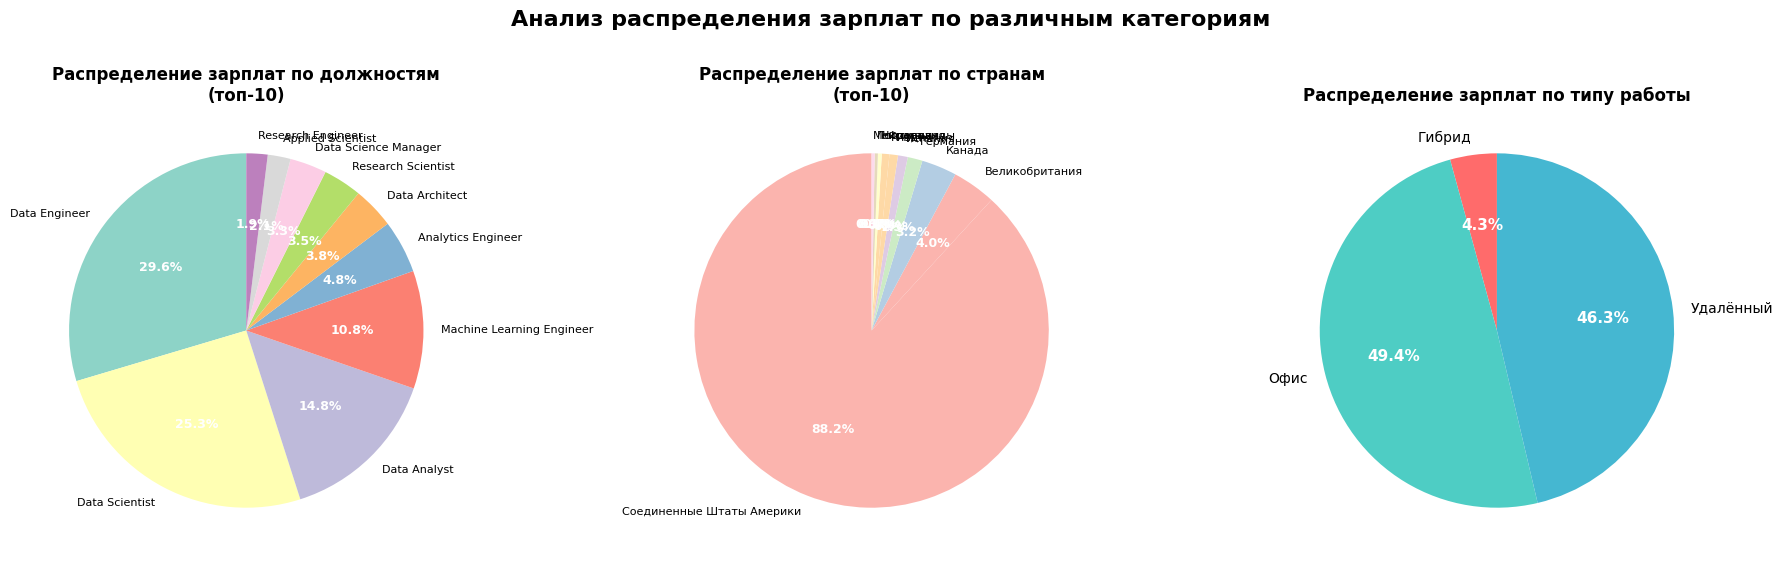

In [41]:
sc.create_pie_charts(df)  

In [42]:
df_clean = sc.portrait_main_analysis(df)


ПОРТРЕТ ИДЕАЛЬНОГО СПЕЦИАЛИСТА:
   Должность: Data Science Tech Lead (средняя зарплата: $375,000)
   Страна проживания: Израиль (средняя зарплата: $423,834)
   Формат работы: Офис (средняя зарплата: $143,690)

ТОП-5 САМЫХ ВЫСОКООПЛАЧИВАЕМЫХ ДОЛЖНОСТЕЙ:
   1. Principal Data Scientist: $198,171 (выборка: 8 чел.)
   2. Director of Data Science: $195,141 (выборка: 11 чел.)
   3. Machine Learning Software Engineer: $192,420 (выборка: 10 чел.)
   4. Applied Scientist: $190,343 (выборка: 31 чел.)
   5. Head of Data: $183,858 (выборка: 10 чел.)

ТОП-5 САМЫХ ВЫСОКООПЛАЧИВАЕМЫХ СТРАН:
   1. Пуэрто-Рико: $166,000 (выборка: 5 чел.)
   2. Соединенные Штаты Америки: $153,972 (выборка: 1893 чел.)
   3. Канада: $130,860 (выборка: 81 чел.)
   4. Ирландия: $114,943 (выборка: 7 чел.)
   5. Япония: $103,538 (выборка: 7 чел.)

РЕЙТИНГ ФОРМАТОВ РАБОТЫ ПО ЗАРПЛАТЕ:
   1. Офис: $143,690 (выборка: 1186 чел.)
   2. Удалённый: $131,822 (выборка: 1211 чел.)
   3. Гибрид: $78,487 (выборка: 187 чел.)


# 
# 

### Международная работа, удалённая занятость

In [28]:
df_result, top_countries_result = sc.f_main_analysis(df)


=== ТОП-10 СТРАН ПО КОЛИЧЕСТВУ ПРОЖИВАЮЩИХ ===
Соединенные Штаты Америки: 1893 чел., 0.3% работают международно
Великобритания: 150 чел., 0.7% работают международно
Канада: 81 чел., 2.5% работают международно
Индия: 70 чел., 21.4% работают международно
Испания: 47 чел., 10.6% работают международно
Германия: 47 чел., 4.3% работают международно
Франция: 37 чел., 16.2% работают международно
Португалия: 18 чел., 22.2% работают международно
Бразилия: 18 чел., 16.7% работают международно
Нидерланды: 15 чел., 13.3% работают международно


alt.Chart(...)


ВЫВОДЫ:
1. 3.7% работников трудятся в другой стране от места проживания
2. Больше всего специалистов проживает в Соединенные Штаты Америки
   Из них 0.3% работают в другой стране
3. Среди международных работников 74.0% работают полностью удаленно
